In [3]:
# Setup
import warnings; warnings.simplefilter('ignore')
# set this to your working directory
WORKING_DIR = '/home/elliott/Dropbox/_Ash_Teaching/2018-09 - Bocconi - Text Data and ML/code'
import os
os.chdir(WORKING_DIR)
%matplotlib inline
import pandas as pd
df1 = pd.read_csv('death-penalty-cases.csv')
df1 = df1[pd.notnull(df1['author_id'])] # drop cases without an author
import numpy as np
vocab = pd.read_pickle('vocab.pkl')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import re
from string import punctuation
translator = str.maketrans('','',punctuation) 
def fix_snippet(txt):
    a = txt.encode("ascii", errors="ignore").decode()
    a = re.sub('\W\w\W', ' ', a).lower()
    a = re.sub('\W\w\w\W', ' ', a)
    a = a.replace('&quot;', ' ').replace ('\n', ' ')
    a = a.translate(translator)
    a = a.replace('deathpenalty',' ')
    a = ' '.join(a.split())
    return a
df1['snippet'] = df1['snippet'].apply(fix_snippet)
df1['snippet'] = df1['snippet'].apply(fix_snippet)
df1.to_csv('cases-processed.csv')

In [4]:
###
# Entity Embeddings
###

# make judge dummy variables
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
J = encoder.fit_transform(df1['author_id'].astype(str))
num_judges = max(J)+1
Y = df1['citeCount'] > 0
Y2 = np.log(1+df1['citeCount'])

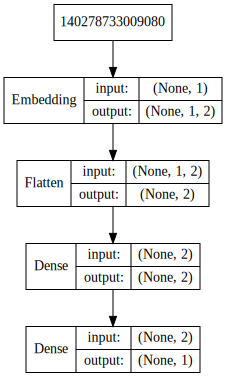

In [5]:
# set up DNN
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

model = Sequential()
model.add(Embedding(num_judges, # number of categories
                    2, # dimensions of embedding
                    input_length=1)) 
model.add(Flatten()) # needed after Embedding
model.add(Dense(2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

dot = model_to_dot(model,
                   show_shapes=True,
                   show_layer_names=False)
SVG(dot.create(prog='dot', format='svg'))

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 2)              5964      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 5,973
Trainable params: 5,973
Non-trainable params: 0
_________________________________________________________________


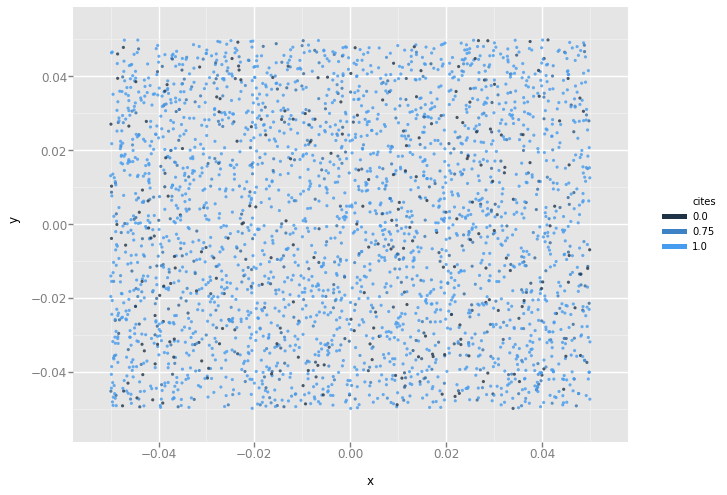

Train on 14572 samples, validate on 3643 samples
Epoch 1/1
14572/14572 [==============================] - 1s 42us/step - loss: 0.4032 - acc: 0.9281 - val_loss: 0.7577 - val_acc: 0.6061


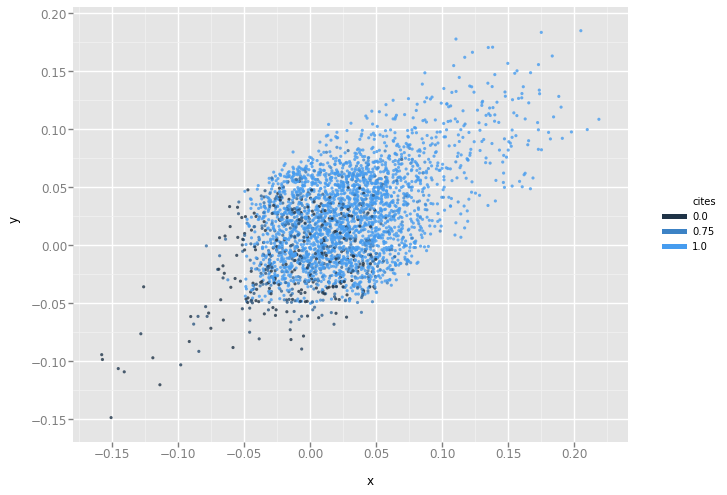

Train on 14572 samples, validate on 3643 samples
Epoch 1/1
14572/14572 [==============================] - 1s 38us/step - loss: 0.1726 - acc: 0.9445 - val_loss: 0.8263 - val_acc: 0.6517


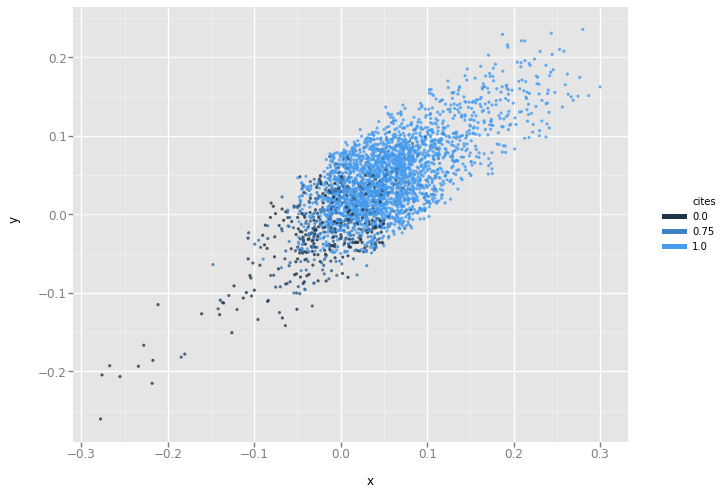

Train on 14572 samples, validate on 3643 samples
Epoch 1/1
14572/14572 [==============================] - 1s 41us/step - loss: 0.1262 - acc: 0.9538 - val_loss: 0.8146 - val_acc: 0.6712


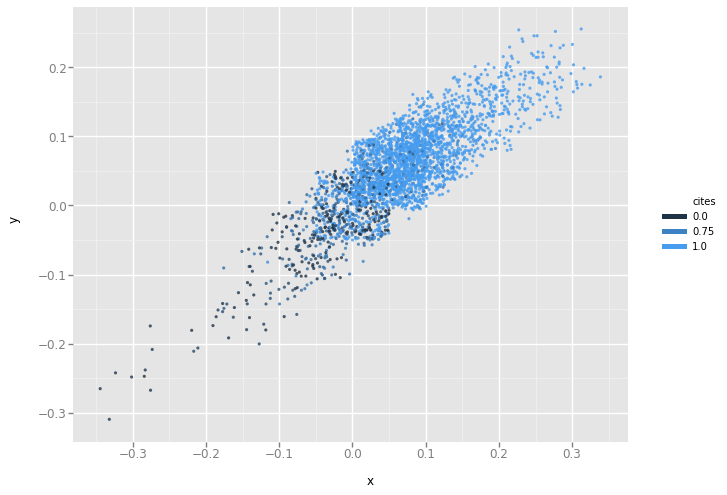

Train on 14572 samples, validate on 3643 samples
Epoch 1/1
14572/14572 [==============================] - 1s 41us/step - loss: 0.1036 - acc: 0.9586 - val_loss: 0.8192 - val_acc: 0.6805


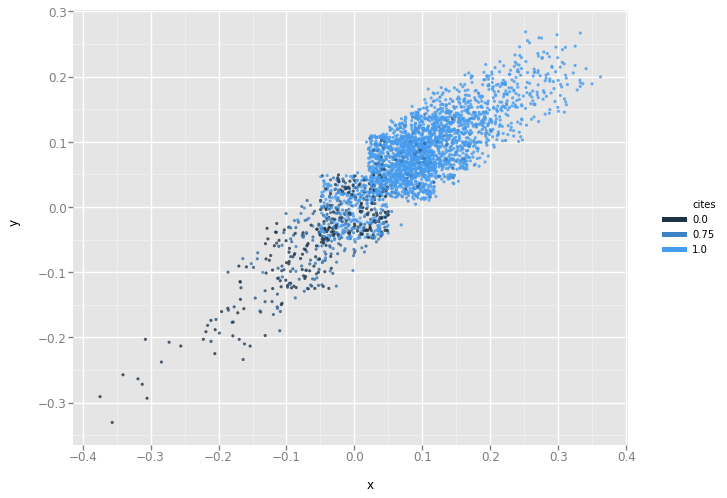

In [7]:
# Visualize the Judge Vectors
import ggplot as gg
judge_cites = dict(Y.groupby(J).mean())
df2 = pd.DataFrame(J,columns=['judge']).drop_duplicates().sort_values('judge')
df2['cites'] = df2['judge'].apply(lambda x: judge_cites[x])

for i in range(5):
    if i > 0:
        model.fit(J,Y,epochs=1, validation_split=.2)
    
    judge_vectors = model.layers[0].get_weights()[0]
    df2['x'] = judge_vectors[:,0]
    df2['y'] = judge_vectors[:,1]    
    chart = gg.ggplot( df2, gg.aes(x='x', y='y', color='cites') ) \
                      + gg.geom_point(size=10, alpha=.8) 
    chart.show()

In [8]:
# Word Embeddings

# convert documents to sequences of word indexes
from keras.preprocessing.text import Tokenizer
num_words = 200
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df1['snippet'])
sequences = tokenizer.texts_to_sequences(df1['snippet'])

# represent data as numrows x maxlen matrix
from keras.preprocessing.sequence import pad_sequences
maxlen = max([len(sent) for sent in sequences]) 
maxlen

77

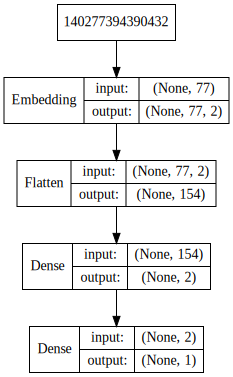

In [9]:
X = pad_sequences(sequences, maxlen=maxlen)

# Model setup
model = Sequential()
model.add(Embedding(num_words,
                    2,
                    input_length=maxlen)) # sequence length
model.add(Flatten()) # 86*2 = 172 dims
model.add(Dense(2))
model.add(Dense(1))
model.compile(optimizer='adam',loss='binary_crossentropy')
dot = model_to_dot(model, show_shapes=True, show_layer_names=False)
SVG(dot.create(prog='dot', format='svg'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 77, 2)             400       
_________________________________________________________________
flatten_2 (Flatten)          (None, 154)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 310       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 713
Trainable params: 713
Non-trainable params: 0
_________________________________________________________________


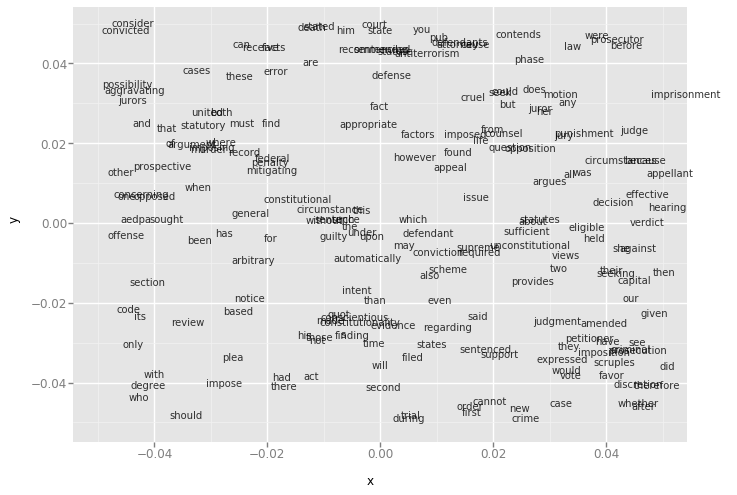

Train on 14572 samples, validate on 3643 samples
Epoch 1/1
14572/14572 [==============================] - 1s 45us/step - loss: 0.8082 - val_loss: 0.8947


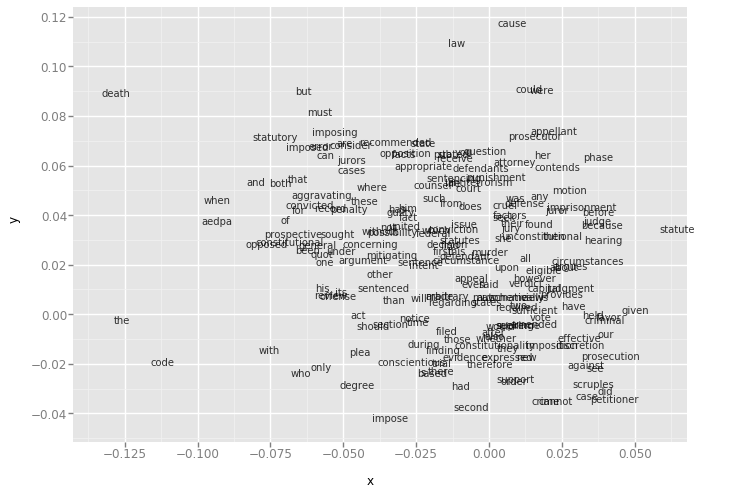

Train on 14572 samples, validate on 3643 samples
Epoch 1/1
14572/14572 [==============================] - 1s 38us/step - loss: 0.2666 - val_loss: 0.9720


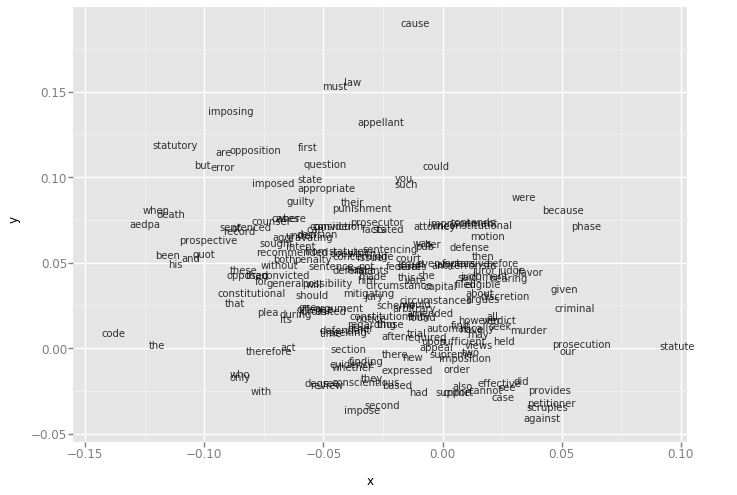

Train on 14572 samples, validate on 3643 samples
Epoch 1/1
14572/14572 [==============================] - 1s 39us/step - loss: 0.2369 - val_loss: 0.9818


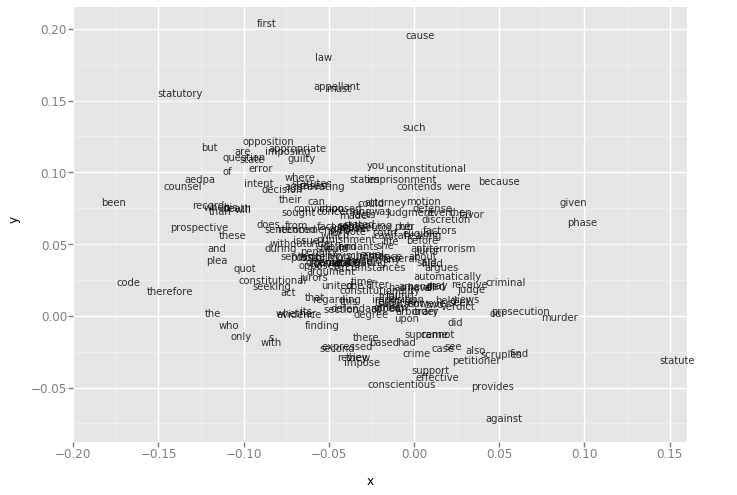

Train on 14572 samples, validate on 3643 samples
Epoch 1/1
14572/14572 [==============================] - 1s 40us/step - loss: 0.2246 - val_loss: 0.9294


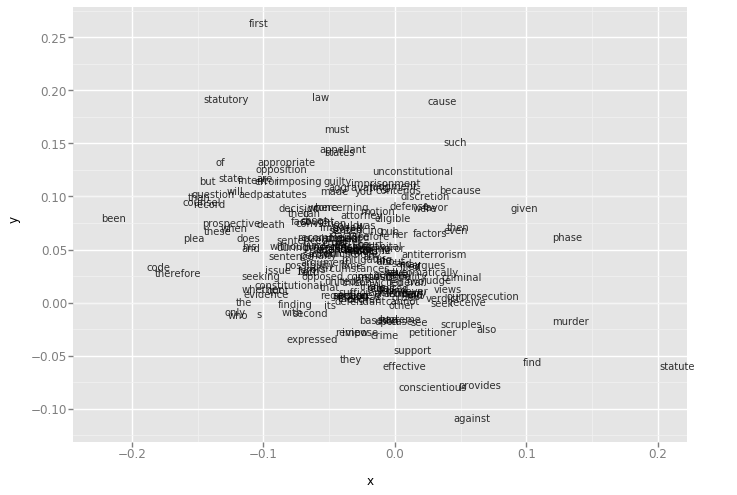

In [11]:
# show the vectors
df3 = pd.DataFrame(list(tokenizer.word_index.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]

for i in range(5):
    if i > 0:
        model.fit(X,Y,epochs=1, validation_split=.2)

    word_vectors = model.layers[0].get_weights()[0]
    df3['x'] = word_vectors[:,0]
    df3['y'] = word_vectors[:,1]
    chart = gg.ggplot( df3, gg.aes(x='x', y='y', label='word') ) \
                      + gg.geom_text(size=10, alpha=.8, label='word') 
    chart.show()

In [12]:
# Word Similarity
from scipy.spatial.distance import cosine

vec_defendants = word_vectors[tokenizer.word_index['defendants']-1]
vec_convicted = word_vectors[tokenizer.word_index['convicted']-1]
vec_against = word_vectors[tokenizer.word_index['against']-1]

print(1-cosine(vec_defendants, vec_convicted))

0.986676454544


In [13]:
print(1-cosine(vec_defendants, vec_against))

-0.853307783604


In [14]:
###
# Word2Vec in gensim
###

# word2vec requires sentences as input
from utils import get_sentences
sentences = []
for doc in df1['snippet']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 5, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v.init_sims(replace=True)

w2v.save('w2v-vectors.pkl')

w2v.wv['judg'] # vector for "judge"

array([-0.0992512 ,  0.08093564, -0.01948434,  0.02921879, -0.03163628,
        0.01411283, -0.07747436, -0.02967072,  0.07063606,  0.01468061,
       -0.04961403, -0.00565243,  0.12908369,  0.08571535, -0.07477693,
        0.00199468,  0.05488882,  0.00405678, -0.03409736,  0.01455178,
       -0.02618112, -0.00328423, -0.09474935,  0.01647738, -0.06269457,
       -0.04583422,  0.04126045,  0.01401766, -0.0337631 , -0.08782142,
        0.00711171, -0.02329621, -0.02435617,  0.03347003,  0.00810587,
        0.04480021,  0.04129802,  0.05309722,  0.04198093, -0.05053527,
       -0.02104271,  0.05505289,  0.14779504,  0.01654868,  0.00741663,
        0.05947132,  0.04913818,  0.00955538,  0.08737372, -0.02547275,
        0.02106874, -0.00782279,  0.00854488,  0.03788859, -0.04787786,
       -0.07079062,  0.0844196 , -0.00180934, -0.00959712,  0.07118601,
        0.06703126, -0.04563923, -0.04283909,  0.1089189 , -0.05218982,
       -0.05842638, -0.08692383,  0.09950141, -0.03561092, -0.01

In [15]:
w2v.wv.similarity('judg','juri') # similarity 

0.72653782

In [16]:
w2v.wv.most_similar('judg') # most similar words

[('juri', 0.726537823677063),
 ('court', 0.7164570689201355),
 ('proceed', 0.6799566149711609),
 ('phase', 0.6607115864753723),
 ('declin', 0.6464661955833435),
 ('accept', 0.626417338848114),
 ('unanim', 0.585892915725708),
 ('alreadi', 0.5818150043487549),
 ('separ', 0.5765491127967834),
 ('commenc', 0.5763197541236877)]

In [17]:
# analogies: judge is to man as __ is to woman
w2v.wv.most_similar(positive=['judg','man'],
                 negative=['woman'])

[('juri', 0.6376981139183044),
 ('evid', 0.6008214950561523),
 ('accept', 0.5902687311172485),
 ('refus', 0.5835240483283997),
 ('recommend', 0.5772887468338013),
 ('fact', 0.5691020488739014),
 ('proceed', 0.553831934928894),
 ('whether', 0.5524836778640747),
 ('show', 0.5482666492462158),
 ('testimoni', 0.5463210344314575)]

In [18]:
# Word2Vec: K-Means Clusters
from sklearn.cluster import KMeans
kmw = KMeans(n_clusters=50)
kmw.fit(w2v.wv.vectors)
judge_clust = kmw.labels_[w2v.wv.vocab['judg'].index]
for i, cluster in enumerate(kmw.labels_):
    if cluster == judge_clust:
        print(w2v.wv.index2word[i])

trial
judg
hear
phase
preclud
circuit
er


In [19]:
###
# Pre-trained vectors
###

import spacy
en = spacy.load('en_core_web_lg')
apple = en('apple') 
apple.vector # vector for 'apple'

array([ -3.63909990e-01,   4.37709987e-01,  -2.04469994e-01,
        -2.28890002e-01,  -1.42269999e-01,   2.73959994e-01,
        -1.14350002e-02,  -1.85780004e-01,   3.73609990e-01,
         7.53390014e-01,  -3.05909991e-01,   2.37409994e-02,
        -7.78760016e-01,  -1.38019994e-01,   6.69919997e-02,
        -6.43030033e-02,  -4.00240004e-01,   1.53090000e+00,
        -1.38969999e-02,  -1.56570002e-01,   2.53659993e-01,
         2.16100007e-01,  -3.27199996e-01,   3.49739999e-01,
        -6.48450032e-02,  -2.95010000e-01,  -6.39230013e-01,
        -6.20170012e-02,   2.45590001e-01,  -6.93340003e-02,
        -3.99670005e-01,   3.09250001e-02,   4.90330011e-01,
         6.75239980e-01,   1.94810003e-01,   5.14880002e-01,
        -3.11489999e-01,  -7.99390003e-02,  -6.20959997e-01,
        -5.32770017e-03,  -1.12640001e-01,   8.35279971e-02,
        -7.69469980e-03,  -1.07879996e-01,   1.66280001e-01,
         4.22729999e-01,  -1.90090001e-01,  -2.90349990e-01,
         4.56300005e-02,

In [20]:
apple.similarity(apple)

1.0

In [21]:
orange = en('orange')
apple.similarity(orange)

0.5618916721419599

In [22]:
import spacy
it = spacy.load('it')
mela = it('mela')
arancia = it('arancia')
mela.similarity(arancia)

0.6897356712282886

In [23]:
# Initializing an embedding layer with pre-trained vectors
embed_dims = len(apple.vector)
embedding_matrix = np.zeros([num_words, embed_dims])
for word, i in tokenizer.word_index.items():
    if i > num_words:
        break
    embedding_vector = en(word).vector
    embedding_matrix[i-1] = embedding_vector    

In [24]:
model = Sequential()
model.add(Embedding(num_words,
                    embed_dims,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False)) # frozen layer
model.add(Flatten()) # 86*300 = 25800 dims
model.add(Dense(64,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 77, 300)           60000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 23100)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                1478464   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 1,538,529
Trainable params: 1,478,529
Non-trainable params: 60,000
_________________________________________________________________


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 2.191629
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.001259
[t-SNE] Error after 300 iterations: 1.077240


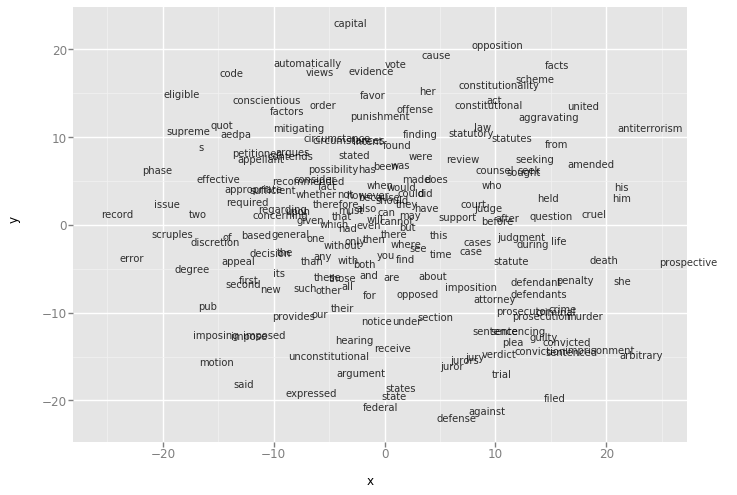

Train on 14572 samples, validate on 3643 samples
Epoch 1/1
14572/14572 [==============================] - 12s 806us/step - loss: 0.9346 - acc: 2.0587e-04 - val_loss: 6.2798 - val_acc: 0.0000e+00
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 2.191629
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.191429
[t-SNE] Error after 300 iterations: 1.101111


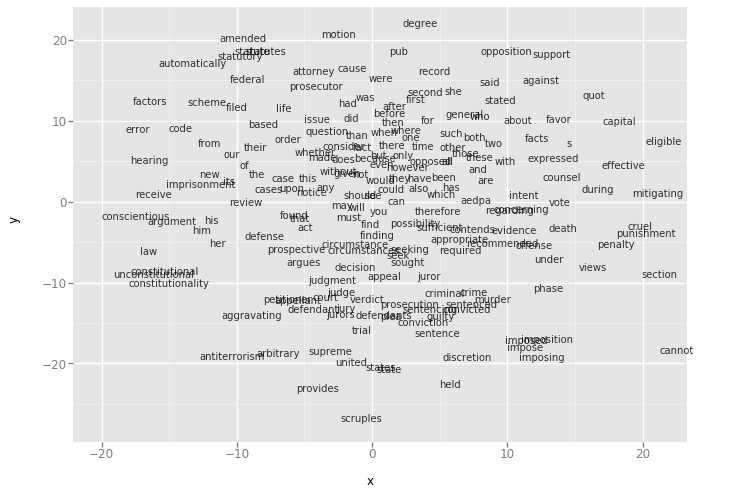

Train on 14572 samples, validate on 3643 samples
Epoch 1/1
14572/14572 [==============================] - 12s 794us/step - loss: 0.9267 - acc: 0.0000e+00 - val_loss: 6.2798 - val_acc: 0.0000e+00
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 2.191629
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.058594
[t-SNE] Error after 300 iterations: 1.109000


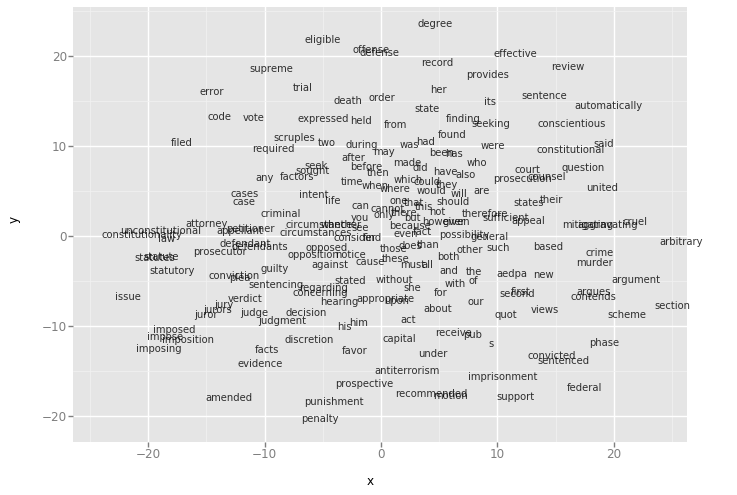

In [26]:
# show the vectors
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)

df3 = pd.DataFrame(list(tokenizer.word_index.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]

for i in range(3):
    if i > 0:
        model.fit(X,Y,epochs=1, validation_split=.2)
    
    word_vectors = model.layers[0].get_weights()[0]
    wv_tsne = tsne.fit_transform(word_vectors)

    df3['x'] = wv_tsne[:,0]
    df3['y'] = wv_tsne[:,1]
    chart = gg.ggplot( df3, gg.aes(x='x', y='y', label='word') ) \
                      + gg.geom_text(size=10, alpha=.8, label='word') 
    chart.show()

In [6]:
###
# Word Mover Distance
###

import spacy
import wmd
nlp = spacy.load('en', 
                 create_pipeline=wmd.WMD.create_spacy_pipeline)
doc1 = nlp("Politician speaks to the media in Illinois.")
doc2 = nlp("The president greets the press in Chicago.")
print(doc1.similarity(doc2))

0.731396076879
